In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import time
import timeit
# execution time
from timeit import default_timer as timer
from datetime import timedelta


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, log_loss, recall_score 
from sklearn.metrics import precision_recall_fscore_support
from timeit import default_timer as timer
from datetime import timedelta

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

import imblearn
from imblearn.over_sampling import RandomOverSampler, SMOTE

In [2]:
from aif360.datasets import BinaryLabelDataset #dataset 
from aif360.explainers import MetricTextExplainer # Explainer
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric # Metrics
from aif360.algorithms.preprocessing.reweighing import Reweighing

from aif360.algorithms.preprocessing.reweighing import Reweighing
from aif360.algorithms.inprocessing import AdversarialDebiasing

from aif360.explainers import Explainer
from aif360.metrics import Metric



pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


In [3]:
raw_df = pd.read_csv('diabetic_dataset.csv')
raw_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99493 entries, 0 to 99492
Data columns (total 48 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   encounter_id              99493 non-null  int64 
 1   patient_nbr               99493 non-null  int64 
 2   race                      99493 non-null  object
 3   gender                    99493 non-null  object
 4   age                       99493 non-null  object
 5   admission_type_id         99493 non-null  int64 
 6   discharge_disposition_id  99493 non-null  int64 
 7   admission_source_id       99493 non-null  int64 
 8   time_in_hospital          99493 non-null  int64 
 9   medical_specialty         99493 non-null  object
 10  num_lab_procedures        99493 non-null  int64 
 11  num_procedures            99493 non-null  int64 
 12  num_medications           99493 non-null  int64 
 13  number_outpatient         99493 non-null  int64 
 14  number_emergency      

In [4]:
raw_df.shape

(99493, 48)

In [5]:
raw_df['race'] = raw_df['race'].replace('?', 'Other')


In [6]:
raw_df['race'].unique()


array(['Caucasian', 'AfricanAmerican', 'Other', 'Asian', 'Hispanic'],
      dtype=object)

In [7]:
raw_df.drop('medical_specialty',axis=1)

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),6,25,1,1,41,...,No,No,No,No,No,No,No,No,No,<30
1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,59,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,11,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,44,...,No,Up,No,No,No,No,No,Ch,Yes,<30
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,51,...,No,Steady,No,No,No,No,No,Ch,Yes,<30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99488,443847548,100162476,AfricanAmerican,Male,[70-80),1,3,7,3,51,...,No,Down,No,No,No,No,No,Ch,Yes,>30
99489,443847782,74694222,AfricanAmerican,Female,[80-90),1,4,5,5,33,...,No,Steady,No,No,No,No,No,No,Yes,NO
99490,443854148,41088789,Caucasian,Male,[70-80),1,1,7,1,53,...,No,Down,No,No,No,No,No,Ch,Yes,>30
99491,443857166,31693671,Caucasian,Female,[80-90),2,3,7,10,45,...,No,Up,No,No,No,No,No,Ch,Yes,>30


In [8]:
# Remove rows where 'admission_type' is 'NA' or 'NULL' (5=NA,6=NULL)
raw_df = raw_df[~raw_df['admission_type_id'].isin([5, 6])]

# Verify the removal
print(raw_df['admission_type_id'].unique())

[1 2 3 4 8 7]


In [9]:
# Remove rows where 'discharge_disposition_id' is expired(11,19,20,21),Null (18),26(unknown),25(not mapble)

raw_df = raw_df[~raw_df['discharge_disposition_id'].isin([11,19,20,21])]

# Verify the removal
print(raw_df['discharge_disposition_id'].unique())

[ 1  3  6  2  5  7  4  8 14 18 12 13 22 17  9 25 23 15 24 28 27]


In [10]:
# Remove rows where 'admission_source_id' is 'UNKNOWN' or 'NULL' (17,20,21)

In [11]:
raw_df = raw_df[~raw_df['admission_source_id'].isin([17,20,21])]
print(raw_df['admission_source_id'].unique())

[ 7  2  4  1  6  5  3  8  9 14 10 22 11 25 13]


In [12]:
#Feature Engineering

In [13]:
raw_df['No_of_total_visits'] = raw_df['number_outpatient'] + raw_df['number_outpatient']
raw_df

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,...,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,No_of_total_visits
1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,?,...,Up,No,No,No,No,No,Ch,Yes,>30,0
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,?,...,No,No,No,No,No,No,No,Yes,NO,4
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,?,...,Up,No,No,No,No,No,Ch,Yes,<30,0
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,?,...,Steady,No,No,No,No,No,Ch,Yes,<30,0
5,35754,82637451,Caucasian,Male,[50-60),2,1,2,3,?,...,Steady,No,No,No,No,No,No,Yes,>30,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99488,443847548,100162476,AfricanAmerican,Male,[70-80),1,3,7,3,?,...,Down,No,No,No,No,No,Ch,Yes,>30,0
99489,443847782,74694222,AfricanAmerican,Female,[80-90),1,4,5,5,?,...,Steady,No,No,No,No,No,No,Yes,NO,0
99490,443854148,41088789,Caucasian,Male,[70-80),1,1,7,1,?,...,Down,No,No,No,No,No,Ch,Yes,>30,2
99491,443857166,31693671,Caucasian,Female,[80-90),2,3,7,10,Surgery-General,...,Up,No,No,No,No,No,Ch,Yes,>30,0


In [14]:
def catg_icd9(icd_code):
    # Remove non-numeric characters for comparison purposes
    numeric_code = ''.join(filter(str.isdigit, icd_code.split('.')[0]))
    
    if numeric_code.isdigit():
        numeric_code = int(numeric_code)
        if 390 <= numeric_code <= 459 or numeric_code == 785:
            return 'Circulatory'
        elif 460 <= numeric_code <= 519 or numeric_code == 786:
            return 'Respiratory'
        elif 520 <= numeric_code <= 579 or numeric_code == 787:
            return 'Digestive'
        elif 250 <= numeric_code <= 250:
            return 'Diabetes'
        elif 800 <= numeric_code <= 999:
            return 'Injury'
        elif 710 <= numeric_code <= 739:
            return 'Musculoskeletal'
        elif 580 <= numeric_code <= 629:
            return 'Genitourinary'
        elif 140 <= numeric_code <= 239:
            return 'Neoplasms'
        else:
            return 'Other'
    elif icd_code.startswith('V'):
        return 'Other'  # V-codes are supplementary classification
    elif icd_code.startswith('E'):
        return 'Other'  # E-codes are external causes of injury
    else:
        return 'Other'

In [15]:
raw_df['cat1']=raw_df['diag_1'].apply(catg_icd9)
raw_df['cat2']=raw_df['diag_2'].apply(catg_icd9)
raw_df['cat3']=raw_df['diag_3'].apply(catg_icd9)

In [16]:
raw_df['cat1'].unique()

array(['Other', 'Neoplasms', 'Circulatory', 'Diabetes', 'Respiratory',
       'Injury', 'Genitourinary', 'Musculoskeletal', 'Digestive'],
      dtype=object)

In [17]:
def get_one_diagnosis(raw_df):
    """
    Process diagnoses to keep only one per patient based on specified rules.
    """
    # Create a new column 'diagnosis' initially set to 'diag-1'
    raw_df['diagnosis'] = raw_df['diag_1']
    
    # Update 'diagnosis' where 'cat2' equals 'cat3'
    raw_df['diagnosis'] = np.where(
        (raw_df['cat2'] == raw_df['cat3']) & (raw_df['cat2'].notnull()),
        raw_df['diag_2'],
        raw_df['diag_1']
    )
    
    return raw_df


In [18]:
# Apply the function
result_df = get_one_diagnosis(raw_df)

# Display the resulting DataFrame
print(result_df)

       encounter_id  patient_nbr             race  gender      age  \
1            149190     55629189        Caucasian  Female  [10-20)   
2             64410     86047875  AfricanAmerican  Female  [20-30)   
3            500364     82442376        Caucasian    Male  [30-40)   
4             16680     42519267        Caucasian    Male  [40-50)   
5             35754     82637451        Caucasian    Male  [50-60)   
...             ...          ...              ...     ...      ...   
99488     443847548    100162476  AfricanAmerican    Male  [70-80)   
99489     443847782     74694222  AfricanAmerican  Female  [80-90)   
99490     443854148     41088789        Caucasian    Male  [70-80)   
99491     443857166     31693671        Caucasian  Female  [80-90)   
99492     443867222    175429310        Caucasian    Male  [70-80)   

       admission_type_id  discharge_disposition_id  admission_source_id  \
1                      1                         1                    7   
2        

In [19]:
result_df['diagnosis']

1           276
2           648
3             8
4           197
5           414
          ...  
99488    250.13
99489       560
99490        38
99491       996
99492       530
Name: diagnosis, Length: 87078, dtype: object

In [20]:
result_df['diagnosis'].apply(catg_icd9)

1              Other
2              Other
3              Other
4          Neoplasms
5        Circulatory
            ...     
99488       Diabetes
99489      Digestive
99490          Other
99491         Injury
99492      Digestive
Name: diagnosis, Length: 87078, dtype: object

In [21]:

# List of medicine columns
medicine_columns = [
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
    'glimepiride', 'acetohexamide', 'glipizide', 'glyburide',
    'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
    'miglitol', 'troglitazone', 'tolazamide', 'examide', 
    'citoglipton', 'insulin', 'glyburide-metformin', 
    'glipizide-metformin', 'glimepiride-pioglitazone','metformin-rosiglitazone',
    'metformin-pioglitazone'
]

# Create the new column 'dosage_up_down' initialized to 0
result_df['dosage_up_down'] = 0

# Update 'dosage_up_down' based on the dosage change in each medicine
for col in medicine_columns:
    result_df['dosage_up_down'] += result_df[col].apply(lambda x: 1 if x == 'Up' else -1 if x == 'Down' else 0)

# Check the result
print(result_df[['dosage_up_down']])

       dosage_up_down
1                   1
2                   0
3                   1
4                   0
5                   0
...               ...
99488              -1
99489               0
99490              -1
99491               1
99492               0

[87078 rows x 1 columns]


In [22]:
result_df['dosage_up_down'].unique()

array([ 1,  0, -1, -2,  2,  3, -3], dtype=int64)

In [23]:
result_df['A1Cresult'].unique()

array([nan, '>7', '>8', 'Norm'], dtype=object)

In [24]:
result_df['A1_converted']=result_df['A1Cresult'].apply(lambda x: 1 if x in ['>8', '>7'] else 0)

In [25]:
result_df['A1_converted'].unique()

array([0, 1], dtype=int64)

In [26]:
result_df['max_glu_serum'].unique()

array([nan, '>300', 'Norm', '>200'], dtype=object)

In [27]:
def convert_glu_serum(value):
    if pd.isna(value):  # Check for NaN values
        return 0
    elif value == '>300':
        return 3
    elif value == '>200':
        return 2
    elif value == 'Norm':
        return 0
    else:
        return value 

In [28]:
result_df['max_glu_serum'] = result_df['max_glu_serum'].apply(convert_glu_serum)

In [29]:
result_df['max_glu_serum'].unique()

array([0, 3, 2], dtype=int64)

In [30]:
# Filter the DataFrame to include only rows where 'readmission' is '<30' or 'no'(readmission <30 days,and no)
#result_df = result_df[result_df['readmitted'].isin(['<30', 'NO'])]


In [31]:
# Replace '<30' with 1 and 'no' with 0
# Replace '<30' with 1 and 'no' with 0
#result_df['readmitted'] = result_df['readmitted'].replace({'<30': 1, 'NO': 0})


In [32]:
result_df = result_df[result_df['readmitted'].isin(['<30', 'NO'])]

In [33]:
result_df['readmitted']=result_df['readmitted'].apply(lambda x: 1 if x in ['<30','>30'] else 0)

C:\Users\Dell\AppData\Local\Temp\ipykernel_576\1020548428.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['readmitted']=result_df['readmitted'].apply(lambda x: 1 if x in ['<30','>30'] else 0)


In [34]:
result_df['readmitted'].unique()

array([0, 1], dtype=int64)

In [35]:
result_df['readmitted'].unique()

array([0, 1], dtype=int64)

In [36]:
result_df['admission_type_id']

2        1
3        1
4        1
6        3
8        2
        ..
99477    3
99479    3
99480    1
99489    1
99492    1
Name: admission_type_id, Length: 56167, dtype: int64

In [37]:
# Group by the 'age_group' column and count the number of entries in each group
age_group_counts = result_df['age'].value_counts().sort_index()
age_group_counts

age
[0-10)        120
[10-20)       423
[20-30)      1023
[30-40)      2243
[40-50)      5476
[50-60)      9834
[60-70)     12584
[70-80)     13902
[80-90)      8982
[90-100)     1580
Name: count, dtype: int64

In [38]:
result_df['age'] = result_df['age'].str.replace('[', '', regex=False).str.replace(')', '', regex=False)


C:\Users\Dell\AppData\Local\Temp\ipykernel_576\2556440464.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['age'] = result_df['age'].str.replace('[', '', regex=False).str.replace(')', '', regex=False)


In [39]:
age_group_counts = result_df['age'].value_counts().sort_index()
age_group_counts

age
0-10        120
10-20       423
20-30      1023
30-40      2243
40-50      5476
50-60      9834
60-70     12584
70-80     13902
80-90      8982
90-100     1580
Name: count, dtype: int64

In [40]:
# Split the age ranges into two separate columns
result_df[['age_start', 'age_end']] = result_df['age'].str.split('-', expand=True)

# Convert the new columns to numeric
result_df['age_start'] = pd.to_numeric(result_df['age_start'], errors='coerce')
result_df['age_end'] = pd.to_numeric(result_df['age_end'], errors='coerce')

# Display the DataFrame after splitting and converting
print("\nDataFrame after splitting the ranges and converting to numeric:")
print(raw_df)

C:\Users\Dell\AppData\Local\Temp\ipykernel_576\3603916740.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df[['age_start', 'age_end']] = result_df['age'].str.split('-', expand=True)
C:\Users\Dell\AppData\Local\Temp\ipykernel_576\3603916740.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df[['age_start', 'age_end']] = result_df['age'].str.split('-', expand=True)
C:\Users\Dell\AppData\Local\Temp\ipykernel_576\3603916740.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy


DataFrame after splitting the ranges and converting to numeric:
       encounter_id  patient_nbr             race  gender      age  \
1            149190     55629189        Caucasian  Female  [10-20)   
2             64410     86047875  AfricanAmerican  Female  [20-30)   
3            500364     82442376        Caucasian    Male  [30-40)   
4             16680     42519267        Caucasian    Male  [40-50)   
5             35754     82637451        Caucasian    Male  [50-60)   
...             ...          ...              ...     ...      ...   
99488     443847548    100162476  AfricanAmerican    Male  [70-80)   
99489     443847782     74694222  AfricanAmerican  Female  [80-90)   
99490     443854148     41088789        Caucasian    Male  [70-80)   
99491     443857166     31693671        Caucasian  Female  [80-90)   
99492     443867222    175429310        Caucasian    Male  [70-80)   

       admission_type_id  discharge_disposition_id  admission_source_id  \
1                  

In [41]:
bins = [0, 30, 60, 100]
labels = ['0-30', '30-60', '60-100']

# Function to categorize age ranges into the defined bins
def categorize_age_range(row):
    if row['age_start'] >= 0 and row['age_end'] <= 30:
        return '0-30'
    elif row['age_start'] >= 30 and row['age_end'] <= 60:
        return '30-60'
    elif row['age_start'] >= 60 and row['age_end'] <= 100:
        return '60-100'
    else:
        return 'Other'

# Apply the function to create a new 'age_bin' column
result_df['age_bin'] = result_df.apply(categorize_age_range, axis=1)


C:\Users\Dell\AppData\Local\Temp\ipykernel_576\637316227.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['age_bin'] = result_df.apply(categorize_age_range, axis=1)


In [42]:
result_df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'medical_specialty', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'No_of_total_visits', 'cat1', 'cat2', 'cat3', 'diagnosis',
       'dosage_up_down', 'A1_converted', 'age_star

In [43]:
result_df = result_df.drop(columns=['diag_1', 'diag_2', 'diag_3','age', 'number_inpatient','number_outpatient','metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'A1Cresult','age_start','age_end'])

In [44]:
result_df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'medical_specialty', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_emergency', 'number_diagnoses',
       'max_glu_serum', 'change', 'diabetesMed', 'readmitted',
       'No_of_total_visits', 'cat1', 'cat2', 'cat3', 'diagnosis',
       'dosage_up_down', 'A1_converted', 'age_bin'],
      dtype='object')

In [45]:
raw_df=result_df.copy()

In [46]:
#result_df = result_df.drop(columns=['max_glu_serum','gender','admission_type_id','discharge_disposition_id','admission_source_id','medical_specialty','diabetesMed','diagnosis','A1_converted','age_bin','change'])

In [47]:
#Target -'readmitted'

In [48]:
raw_df['readmitted'].unique()

array([0, 1], dtype=int64)

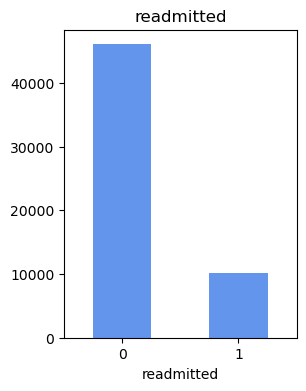

In [49]:
plt.figure(figsize=(3,4))
raw_df['readmitted'].value_counts().plot(kind='bar', rot=0, color='#6495ED')
plt.title('readmitted')
plt.show()

In [50]:
num_cols = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 
            'number_diagnoses']
raw_df[num_cols].describe()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses
count,56167.000000,56167.000000,56167.000000,56167.000000,56167.000000
mean,4.349974,43.129062,1.389054,15.812417,7.326313
std,2.977313,19.202491,1.725069,8.393576,1.985048
min,1.000000,1.000000,0.000000,1.000000,1.000000
25%,2.000000,33.000000,0.000000,10.000000,6.000000
50%,4.000000,44.000000,1.000000,14.000000,8.000000
75%,6.000000,56.000000,2.000000,20.000000,9.000000
max,14.000000,132.000000,6.000000,81.000000,16.000000


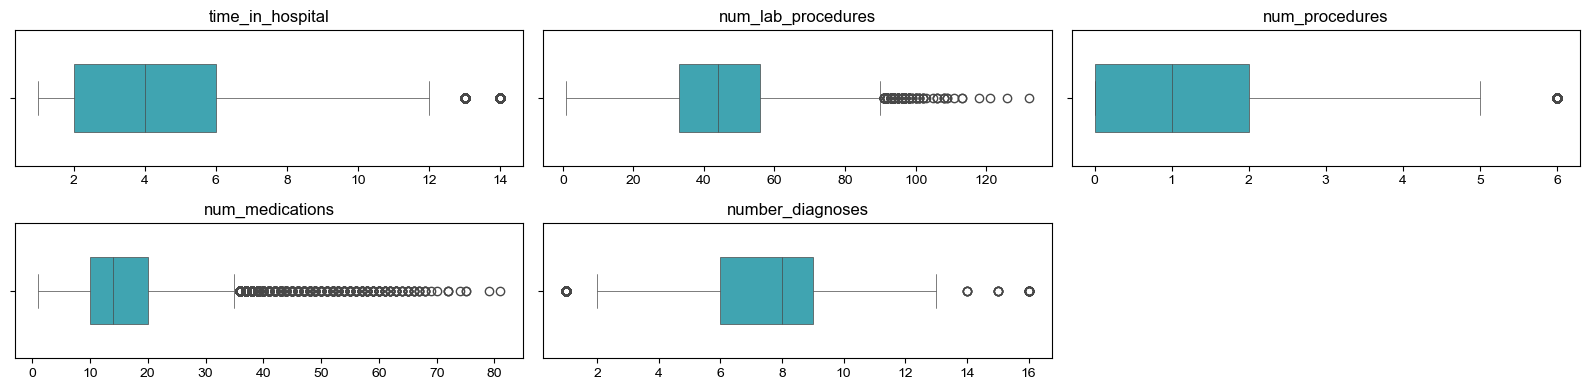

In [51]:
num_plots = len(num_cols)
cols_per_row = 3
rows = (num_plots - 1) // cols_per_row + 1

fig, axes = plt.subplots(nrows=rows, ncols=cols_per_row, figsize=(16, 4))
axes = axes.flatten()
sns.set_style("white")

for i, column in enumerate(num_cols):
    ax = axes[i]
    sns.boxplot(data=raw_df, x=column, ax=ax, linewidth=0.5,
                color='#2DB2C4', width=0.5)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(column)

for i in range(num_plots, len(axes)):
    fig.delaxes(axes[i])
    
plt.tight_layout()
plt.show()

C:\Users\Dell\AppData\Local\Temp\ipykernel_576\2804848023.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=raw_df, x=column, ax=ax,
C:\Users\Dell\AppData\Local\Temp\ipykernel_576\2804848023.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=raw_df, x=column, ax=ax,
C:\Users\Dell\AppData\Local\Temp\ipykernel_576\2804848023.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=raw_df, x=column, ax=ax,
C:\Users\Dell\AppData\Local\Temp\ipykernel_576\2804848023.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=raw_df, x=column, ax=ax,
C:\Users\Dell\AppData\Local\Temp\ipykernel_576\2804848023.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=raw_df, x=column, ax=ax,


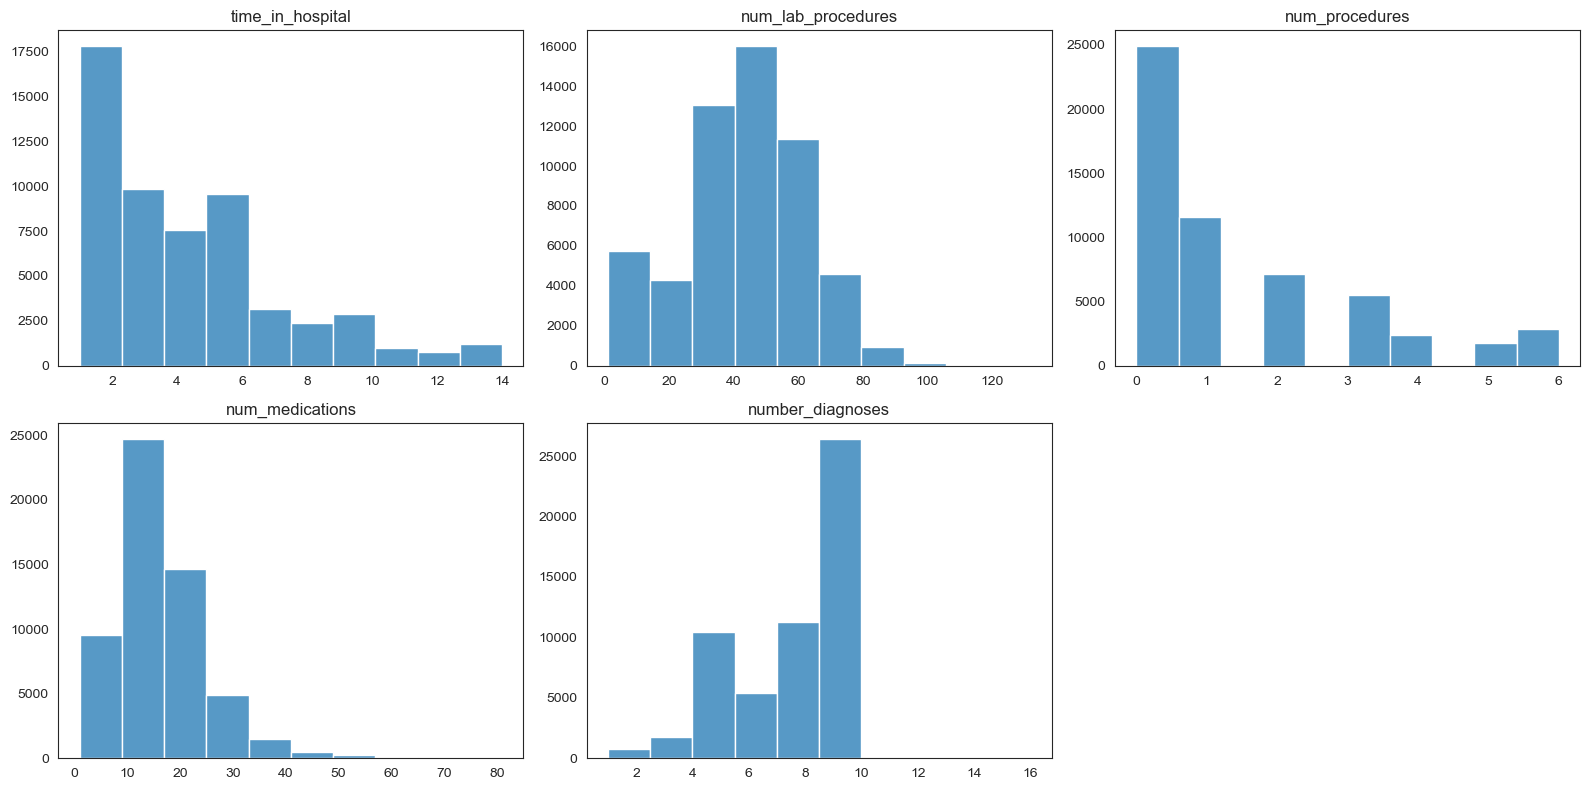

In [52]:
num_plots = len(num_cols)
cols_per_row = 3
rows = (num_plots - 1) // cols_per_row + 1

fig, axes = plt.subplots(nrows=rows, ncols=cols_per_row, figsize=(16, 8))
axes = axes.flatten()
sns.set_style("white")

for i, column in enumerate(num_cols):
    ax = axes[i]
    sns.histplot(data=raw_df, x=column, ax=ax,
                 palette=['#2DB2C4','#C42D2D'],
                 bins=10, multiple='stack')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(column)

for i in range(num_plots, len(axes)):
    fig.delaxes(axes[i])
    
plt.tight_layout()
plt.show()

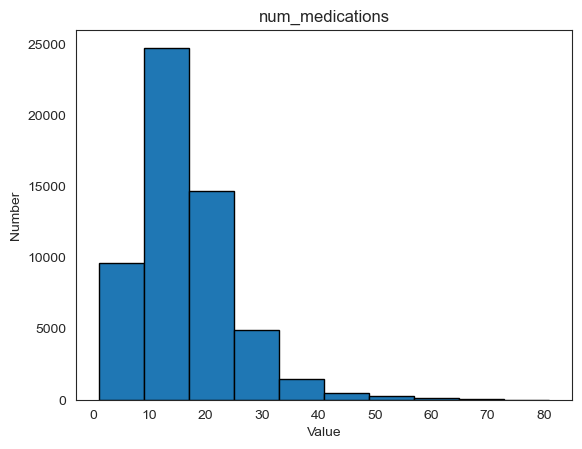

In [53]:
# Plotting the histogram
plt.hist(raw_df['num_medications'], bins=10, edgecolor='black')

# Adding title and labels
plt.title('num_medications')
plt.xlabel('Value')
plt.ylabel('Number')

# Display the plot
plt.show()

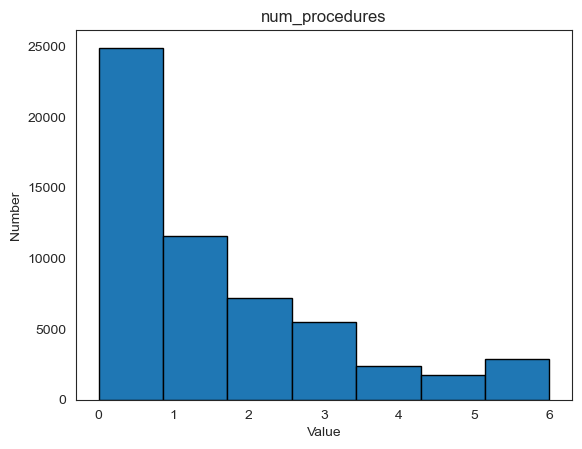

In [54]:
# Plotting the histogram
plt.hist(raw_df['num_procedures'], bins=7, edgecolor='black')

# Adding title and labels
plt.title('num_procedures')
plt.xlabel('Value')
plt.ylabel('Number')

# Display the plot
plt.show()

In [55]:
#adjustment for Schweness of histogram

In [56]:
raw_df['time_in_hospital'] = np.sqrt(raw_df['time_in_hospital'])
raw_df['No_of_total_visits'] = np.sqrt(raw_df['No_of_total_visits'])
raw_df['number_emergency'] = np.sqrt(raw_df['number_emergency'])
raw_df['num_procedures'] = np.sqrt(raw_df['num_procedures'])
raw_df['num_medications'] = np.sqrt(raw_df['num_medications'])





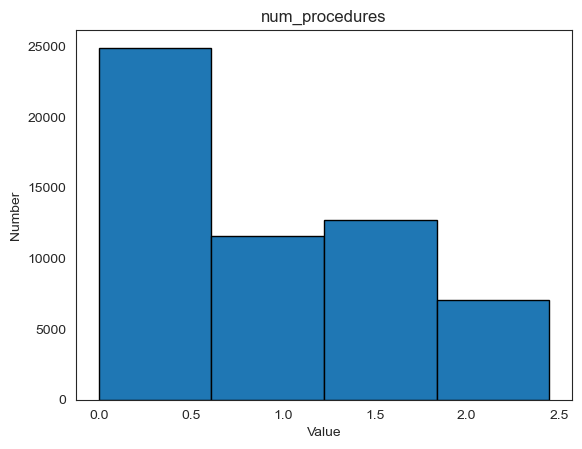

In [57]:
plt.hist(raw_df['num_procedures'], bins=4, edgecolor='black')

# Adding title and labels
plt.title('num_procedures')
plt.xlabel('Value')
plt.ylabel('Number')

# Display the plot
plt.show()

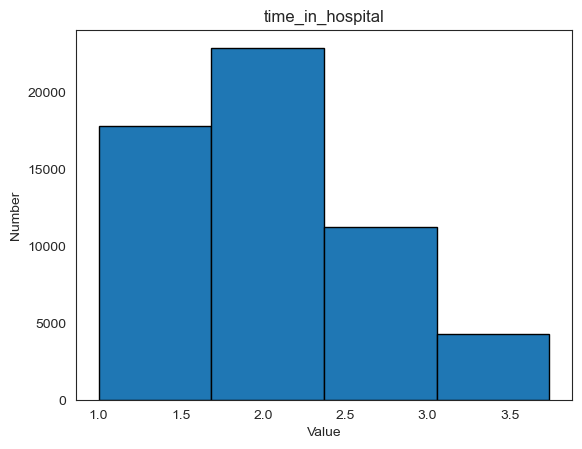

In [58]:
plt.hist(raw_df['time_in_hospital'], bins=4, edgecolor='black')

# Adding title and labels
plt.title('time_in_hospital')
plt.xlabel('Value')
plt.ylabel('Number')

# Display the plot
plt.show()

In [59]:
#Categorical columns

In [60]:
raw_df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'medical_specialty', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_emergency', 'number_diagnoses',
       'max_glu_serum', 'change', 'diabetesMed', 'readmitted',
       'No_of_total_visits', 'cat1', 'cat2', 'cat3', 'diagnosis',
       'dosage_up_down', 'A1_converted', 'age_bin'],
      dtype='object')

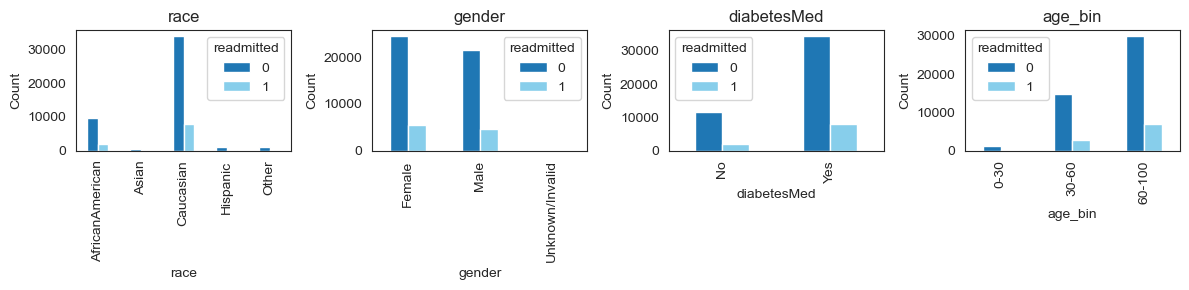

In [61]:
# Assuming raw_df is already defined and contains the required data
cat_col = ['race', 'gender', 'diabetesMed', 'age_bin']
cat_plots = len(cat_col)
cols_per_row = 4
rows = (cat_plots + cols_per_row - 1) // cols_per_row

fig, axes = plt.subplots(nrows=rows, ncols=cols_per_row, figsize=(12, 3 * rows))
axes = axes.flatten()
sns.set_style("white")

for i, column in enumerate(cat_col):
    ax = axes[i]
    # Create a contingency table
    contingency_tab = pd.crosstab(raw_df[column], raw_df['readmitted'])
    # Plot using seaborn barplot for each level of the categorical variable
    contingency_tab.plot(kind='bar', ax=ax, color=['#1f77b4', '#87CEEB'])
    ax.set_xlabel(column)
    ax.set_ylabel('Count')
    ax.set_title(column)
    ax.legend(title='readmitted')

# Remove empty subplots if the number of plots doesn't fill the entire grid
for i in range(cat_plots, len(axes)):
    fig.delaxes(axes[i])

# Adjust layout
plt.tight_layout()
plt.show()

In [62]:
num_cols_new = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 
            'number_diagnoses','number_emergency','No_of_total_visits']

In [63]:
raw_df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'medical_specialty', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_emergency', 'number_diagnoses',
       'max_glu_serum', 'change', 'diabetesMed', 'readmitted',
       'No_of_total_visits', 'cat1', 'cat2', 'cat3', 'diagnosis',
       'dosage_up_down', 'A1_converted', 'age_bin'],
      dtype='object')

In [64]:
# Calculate the correlation matrix
corr_matrix = raw_df[num_cols_new].corr()
corr_matrix


,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,number_emergency,No_of_total_visits
time_in_hospital,1.000000,0.362643,0.186227,0.474801,0.255906,-0.002667,-0.008506
num_lab_procedures,0.362643,1.000000,0.004727,0.270727,0.164621,0.017396,0.009090
num_procedures,0.186227,0.004727,1.000000,0.391988,0.057132,-0.048252,-0.018817
num_medications,0.474801,0.270727,0.391988,1.000000,0.284774,0.025425,0.056844
number_diagnoses,0.255906,0.164621,0.057132,0.284774,1.000000,0.078901,0.112558
number_emergency,-0.002667,0.017396,-0.048252,0.025425,0.078901,1.000000,0.173001
No_of_total_visits,-0.008506,0.009090,-0.018817,0.056844,0.112558,0.173001,1.000000


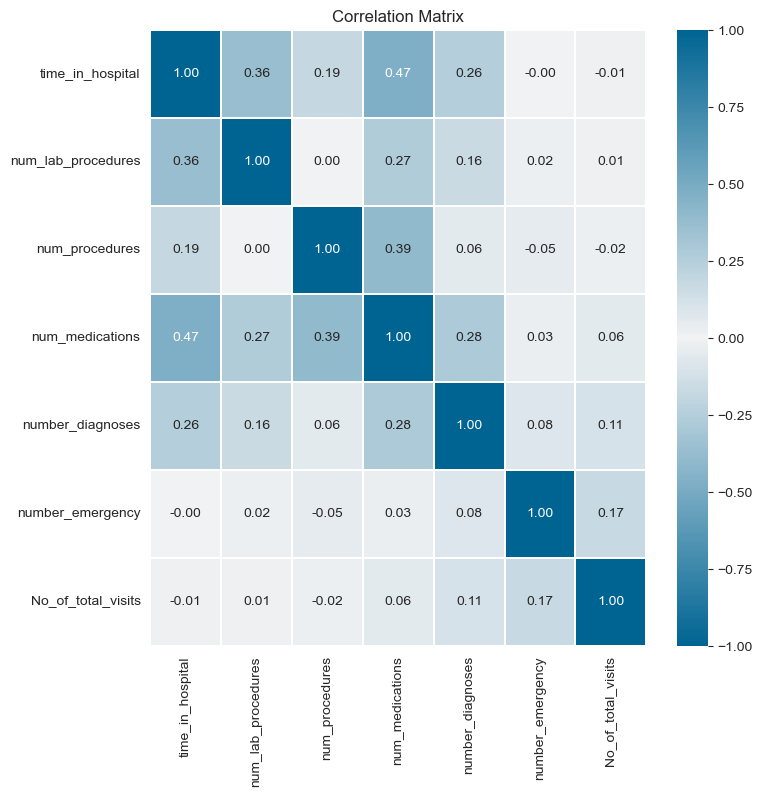

In [65]:
# Custom blue colormap
blue_cmap = sns.diverging_palette(240, 240, s=100, l=40, n=9, as_cmap=True)

# Create the heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(data=corr_matrix, vmin=-1, vmax=1, cmap=blue_cmap, annot=True, cbar=True, fmt=".2f", linewidths=0.1)
plt.title('Correlation Matrix')
plt.show()


In [66]:
import seaborn as sns
import matplotlib
print("Seaborn version:", sns.__version__)
print("Matplotlib version:", matplotlib.__version__)
%matplotlib inline

Seaborn version: 0.13.2
Matplotlib version: 3.8.4


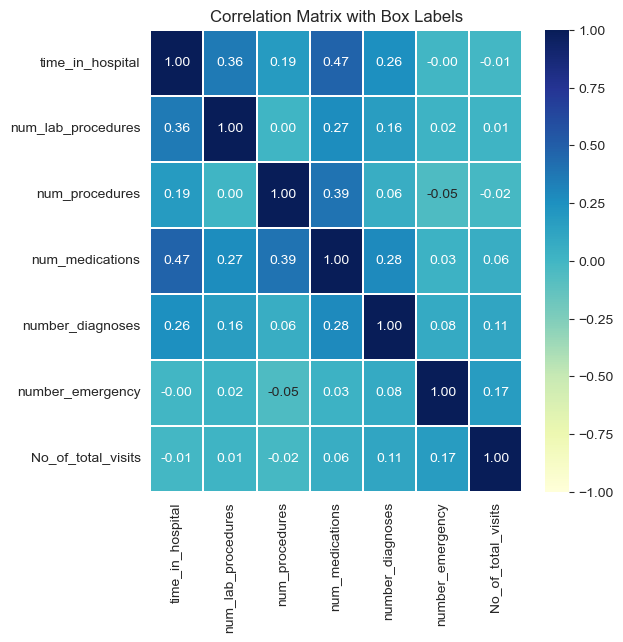

In [67]:
plt.figure(figsize=(6, 6))
ax = sns.heatmap(
    data=corr_matrix, 
    vmin=-1, vmax=1, 
    cmap='YlGnBu', 
    annot=True,       # Ensure annotations are enabled
    cbar=True, 
    fmt=".2f",        # Format for annotation
    linewidths=0.1    # Width of lines between cells
)

# Title for the heatmap
plt.title('Correlation Matrix with Box Labels')
plt.show()

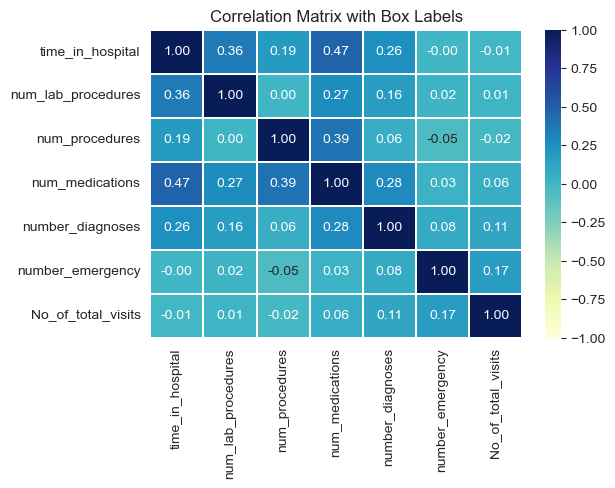

In [68]:
plt.figure(figsize=(6,4))
ax = sns.heatmap(
    data=corr_matrix, 
    vmin=-1, vmax=1, 
    cmap='YlGnBu', 
    annot=True,       # Ensure annotations are enabled
    cbar=True, 
    fmt=".2f",        # Format for annotation
    linewidths=0.1    # Width of lines between cells
)

# Title for the heatmap
plt.title('Correlation Matrix with Box Labels')
plt.show()

In [69]:
# Define the mapping for races
race_mapping = {
    'Caucasian': 1,
    'AfricanAmerican': 0,
    'Asian': 0,
    'Hispanic': 0,
    'Other': 0  # Assuming 'other' is another category in your data, if not you can include other specific races
}

# Map the race column to numerical values
df=raw_df.copy()
raw_df['race'] = raw_df['race'].replace(race_mapping)


In [70]:
raw_df['race'].unique()

array([0, 1], dtype=int64)

In [71]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56167 entries, 2 to 99492
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   encounter_id              56167 non-null  int64  
 1   patient_nbr               56167 non-null  int64  
 2   race                      56167 non-null  int64  
 3   gender                    56167 non-null  object 
 4   admission_type_id         56167 non-null  int64  
 5   discharge_disposition_id  56167 non-null  int64  
 6   admission_source_id       56167 non-null  int64  
 7   time_in_hospital          56167 non-null  float64
 8   medical_specialty         56167 non-null  object 
 9   num_lab_procedures        56167 non-null  int64  
 10  num_procedures            56167 non-null  float64
 11  num_medications           56167 non-null  float64
 12  number_emergency          56167 non-null  float64
 13  number_diagnoses          56167 non-null  int64  
 14  max_glu_ser

In [72]:
# Manually specify the columns to be converted
categorical_columns = ['race','admission_type_id','admission_source_id','medical_specialty','max_glu_serum','readmitted','A1_converted']

# Convert specified columns to 'category' dtype
for col in categorical_columns:
    raw_df[col] = raw_df[col].astype('object')

# Verify the conversion
print(raw_df.dtypes)

encounter_id                  int64
patient_nbr                   int64
race                         object
gender                       object
admission_type_id            object
discharge_disposition_id      int64
admission_source_id          object
time_in_hospital            float64
medical_specialty            object
num_lab_procedures            int64
num_procedures              float64
num_medications             float64
number_emergency            float64
number_diagnoses              int64
max_glu_serum                object
change                       object
diabetesMed                  object
readmitted                   object
No_of_total_visits          float64
cat1                         object
cat2                         object
cat3                         object
diagnosis                    object
dosage_up_down                int64
A1_converted                 object
age_bin                      object
dtype: object


In [73]:
from scipy.stats import chi2_contingency, pointbiserialr, f_oneway


In [74]:
# Chi-Square Test for Categorical vs Categorical
results = {}
for col in raw_df.select_dtypes(include=['object']).columns:
    if col != 'readmitted':
        contingency_table = pd.crosstab(raw_df['readmitted'], raw_df[col])
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        results[col] = {'Test': 'Chi-Square', 'p-value': p}
 # Display results
results_df = pd.DataFrame(results).T
print(results_df)

                           Test  p-value
race                 Chi-Square      0.0
gender               Chi-Square  0.09917
admission_type_id    Chi-Square      0.0
admission_source_id  Chi-Square      0.0
medical_specialty    Chi-Square      0.0
max_glu_serum        Chi-Square      0.0
change               Chi-Square      0.0
diabetesMed          Chi-Square      0.0
cat1                 Chi-Square      0.0
cat2                 Chi-Square      0.0
cat3                 Chi-Square      0.0
diagnosis            Chi-Square      0.0
A1_converted         Chi-Square      0.0
age_bin              Chi-Square      0.0


In [75]:
# ANOVA for Numerical vs Categorical
results={}
for col in df.select_dtypes(include=['int64', 'float64']).columns:
    groups = [raw_df[col][raw_df['readmitted'] == category] for category in raw_df['readmitted'].unique()]
    f_value, p_value = f_oneway(*groups)
    results[col] = {'Test': 'ANOVA', 'p-value': p_value}
    # Display results
results_df = pd.DataFrame(results).T
print(results_df)


                           Test   p-value
encounter_id              ANOVA       0.0
patient_nbr               ANOVA       0.0
admission_type_id         ANOVA       0.0
discharge_disposition_id  ANOVA       0.0
admission_source_id       ANOVA       0.0
time_in_hospital          ANOVA       0.0
num_lab_procedures        ANOVA       0.0
num_procedures            ANOVA  0.000005
num_medications           ANOVA       0.0
number_emergency          ANOVA       0.0
number_diagnoses          ANOVA       0.0
max_glu_serum             ANOVA       0.0
readmitted                ANOVA       0.0
No_of_total_visits        ANOVA       0.0
dosage_up_down            ANOVA  0.000023
A1_converted              ANOVA       0.0


C:\Users\Dell\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


In [76]:
#Not removing age as in medical data , age ia a important factor, not removing outliers as these might be sensitive for medical records.

In [77]:
#Label encoding in categorical variables

In [78]:
# Instantiate the LabelEncoder
from sklearn.preprocessing import LabelEncoder 
label_encoder = LabelEncoder()

# Apply label encoding to each categorical column
for col in ['gender','admission_type_id','discharge_disposition_id','admission_source_id','medical_specialty','diabetesMed','diagnosis','A1_converted','age_bin','change','max_glu_serum']:
    raw_df[col + '_label_encoded'] = label_encoder.fit_transform(raw_df[col])

raw_df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'medical_specialty', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_emergency', 'number_diagnoses',
       'max_glu_serum', 'change', 'diabetesMed', 'readmitted',
       'No_of_total_visits', 'cat1', 'cat2', 'cat3', 'diagnosis',
       'dosage_up_down', 'A1_converted', 'age_bin', 'gender_label_encoded',
       'admission_type_id_label_encoded',
       'discharge_disposition_id_label_encoded',
       'admission_source_id_label_encoded', 'medical_specialty_label_encoded',
       'diabetesMed_label_encoded', 'diagnosis_label_encoded',
       'A1_converted_label_encoded', 'age_bin_label_encoded',
       'change_label_encoded', 'max_glu_serum_label_encoded'],
      dtype='object')

In [79]:
raw_df = raw_df.drop(columns=['max_glu_serum','gender','admission_type_id','discharge_disposition_id','admission_source_id','medical_specialty','diabetesMed','diagnosis','A1_converted','age_bin','change','encounter_id','patient_nbr','cat1','cat2','cat3']) 

### Main Dataset disperate impact

In [80]:
raw_df['readmitted'].unique()

array([0, 1], dtype=object)

In [81]:
raw_df['readmitted'] = raw_df['readmitted'].astype(int)

In [82]:
raw_df['readmitted']

2        0
3        1
4        1
6        1
8        1
        ..
99477    1
99479    0
99480    0
99489    0
99492    0
Name: readmitted, Length: 56167, dtype: int32

In [83]:
raw_df.columns

Index(['race', 'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_emergency', 'number_diagnoses', 'readmitted',
       'No_of_total_visits', 'dosage_up_down', 'gender_label_encoded',
       'admission_type_id_label_encoded',
       'discharge_disposition_id_label_encoded',
       'admission_source_id_label_encoded', 'medical_specialty_label_encoded',
       'diabetesMed_label_encoded', 'diagnosis_label_encoded',
       'A1_converted_label_encoded', 'age_bin_label_encoded',
       'change_label_encoded', 'max_glu_serum_label_encoded'],
      dtype='object')

In [84]:
raw_df.shape

(56167, 21)

In [85]:
# Making our data into a Binary label dataset
aif_fair = BinaryLabelDataset(favorable_label = 1, unfavorable_label = 0, df=raw_df,
                                                      label_names=["readmitted"],
                                                     protected_attribute_names=["race"],
                                              privileged_protected_attributes = [1,1])

In [86]:
#Disparate impact measurement for Race in main dataset
#Taking the prieveleged group as Caucasian



metric_aif= BinaryLabelDatasetMetric(aif_fair,
                                      unprivileged_groups=[{"race":0}],
                                      privileged_groups=[{"race":1}]) 
explainer_aif = MetricTextExplainer(metric_aif)

print(explainer_aif.disparate_impact())

Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.8663512531509576


In [87]:
train_set, test_set = train_test_split(raw_df, test_size=0.2, random_state=42)



In [88]:
train_set_latest=train_set.copy()
test_set_latest=test_set.copy()

Checking of readmission on trainset

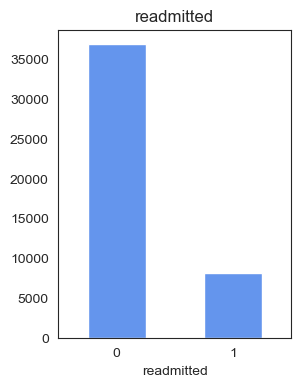

In [89]:
plt.figure(figsize=(3,4))
train_set['readmitted'].value_counts().plot(kind='bar', rot=0, color='#6495ED')
plt.title('readmitted')
plt.show()

In [90]:
readmission_counts=raw_df['readmitted'].value_counts()

In [91]:
readmission_percentages = (readmission_counts / len(raw_df)
) * 100
readmission_percentages

readmitted
0    81.96984
1    18.03016
Name: count, dtype: float64

In [92]:
x_train = train_set.drop(columns=['readmitted'])
y_train = train_set['readmitted']

In [93]:
x_test=test_set.drop(columns=['readmitted'])
y_test=test_set['readmitted']

In [94]:
x_train.shape

(44933, 20)

In [95]:
y_train_encoded = label_encoder.fit_transform(y_train)

In [96]:
y_test_encoded = label_encoder.fit_transform(y_test)

In [97]:
#Apply smote for class imbalance

In [98]:
# Plot class distribution before SMOTE
from collections import Counter
def plot_class_distribution(y, title):
    counter = Counter(y)
    plt.bar(counter.keys(), counter.values())
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.xticks([0, 1])
    plt.show()

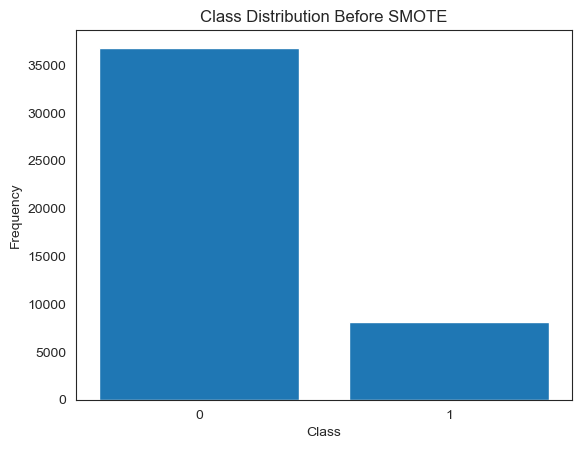

In [99]:
plot_class_distribution(y_train_encoded, 'Class Distribution Before SMOTE')

In [100]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(x_train, y_train_encoded )

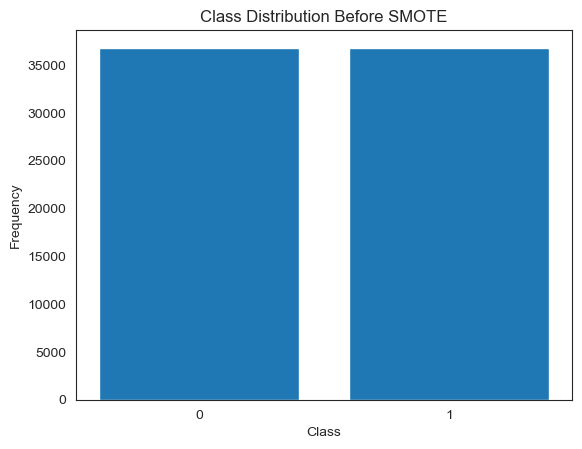

In [101]:
plot_class_distribution(y_train_res, 'Class Distribution Before SMOTE')

In [102]:
scaler = MinMaxScaler()

# Fit the scaler on the training features and transform both train and test features
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_res), columns=x_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns)

Train the model (Base model)

In [103]:
#Computation of confusion matrix to visualise the model predictions against the actual labels
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
def conf_mat(y_pred, ytest):
    class_names = [0,1]
    tick_marks_y = [0.5, 2]
    tick_marks_x = [0.5, 2]
    confusion_matrix = metrics.confusion_matrix(ytest, y_pred)
    confusion_matrix_df = pd.DataFrame(confusion_matrix, range(2), range(2))
    plt.figure(figsize = (6, 4.75))
    sns.set(font_scale = 1.4) # label size
    plt.title("Confusion Matrix")
    sns.heatmap(confusion_matrix_df, annot = True, annot_kws = {"size": 16}, fmt = 'd',cmap='seismic')
 # font size
    plt.yticks(tick_marks_y, class_names, rotation = 'vertical')
    plt.xticks(tick_marks_x, class_names, rotation = 'horizontal')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)
    plt.show()

In [104]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

Execution time of Decision Tree is: 0.433 seconds
Accuracy: 0.70
Confusion Matrix:
[[7313 1897]
 [1475  549]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.79      0.81      9210
           1       0.22      0.27      0.25      2024

    accuracy                           0.70     11234
   macro avg       0.53      0.53      0.53     11234
weighted avg       0.72      0.70      0.71     11234



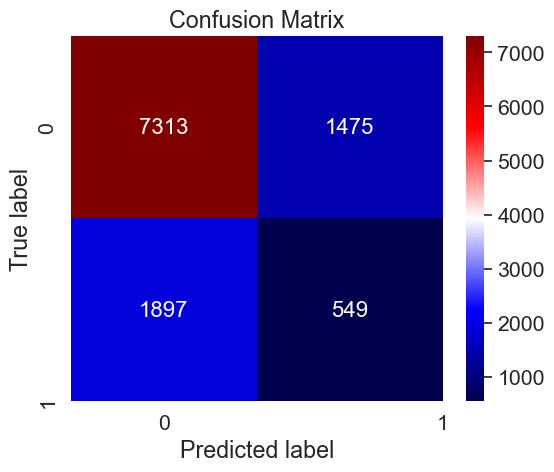

In [105]:
# Initialize the Decision Tree classifier
start = time.time()
dt_classifier = DecisionTreeClassifier(random_state=42)

# Fit the model on the training data
dt_classifier.fit(X_train_scaled, y_train_res)

# Predict on the test data
y_pred = dt_classifier.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test_encoded, y_pred)
#Time
dec_tree_duration = time.time()-start
#conf_matrix = conf_mat(y_test_encoded, y_pred)
class_report = classification_report(y_test_encoded, y_pred)
confusion_matrix = metrics.confusion_matrix(y_test_encoded, y_pred)

print(f'Execution time of Decision Tree is: {dec_tree_duration:.3f} seconds')
print(f'Accuracy: {accuracy:.2f}')
print('Confusion Matrix:')
print(confusion_matrix)
print('Classification Report:')
print(class_report)

conf_mat(y_test_encoded, y_pred)

In [106]:
###Random forest Model

In [107]:
# fit Random Forest model 
from sklearn.ensemble import RandomForestClassifier
start = time.time()
#Running Random Forest Model on the original data without implementing reweighing
model_rf = RandomForestClassifier(n_estimators=300,min_samples_split=10, max_depth=10,n_jobs=-1)
model_rf.fit(X_train_scaled, y_train_res)

RandomForestClassifier(max_depth=10, min_samples_split=10, n_estimators=300,
                       n_jobs=-1)

Execution time of Decision Tree is: 5.427 seconds
Accuracy: 0.78
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      9210
           1       0.28      0.16      0.20      2024

    accuracy                           0.78     11234
   macro avg       0.56      0.53      0.54     11234
weighted avg       0.73      0.78      0.75     11234



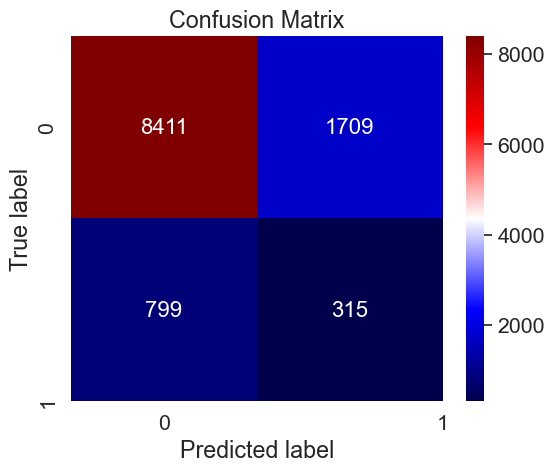

In [108]:
y_pred_test = model_rf.predict(X_test_scaled)

#Time
RF_duration = time.time()-start
acc_test = accuracy_score(y_true=y_test_encoded, y_pred=y_pred_test)
class_report_rf = classification_report(y_test_encoded, y_pred_test)

print(f'Execution time of Decision Tree is: {RF_duration:.3f} seconds')
print(f'Accuracy: {acc_test:.2f}')
print('Classification Report:')
print(class_report_rf)

conf_mat(y_test_encoded, y_pred_test)


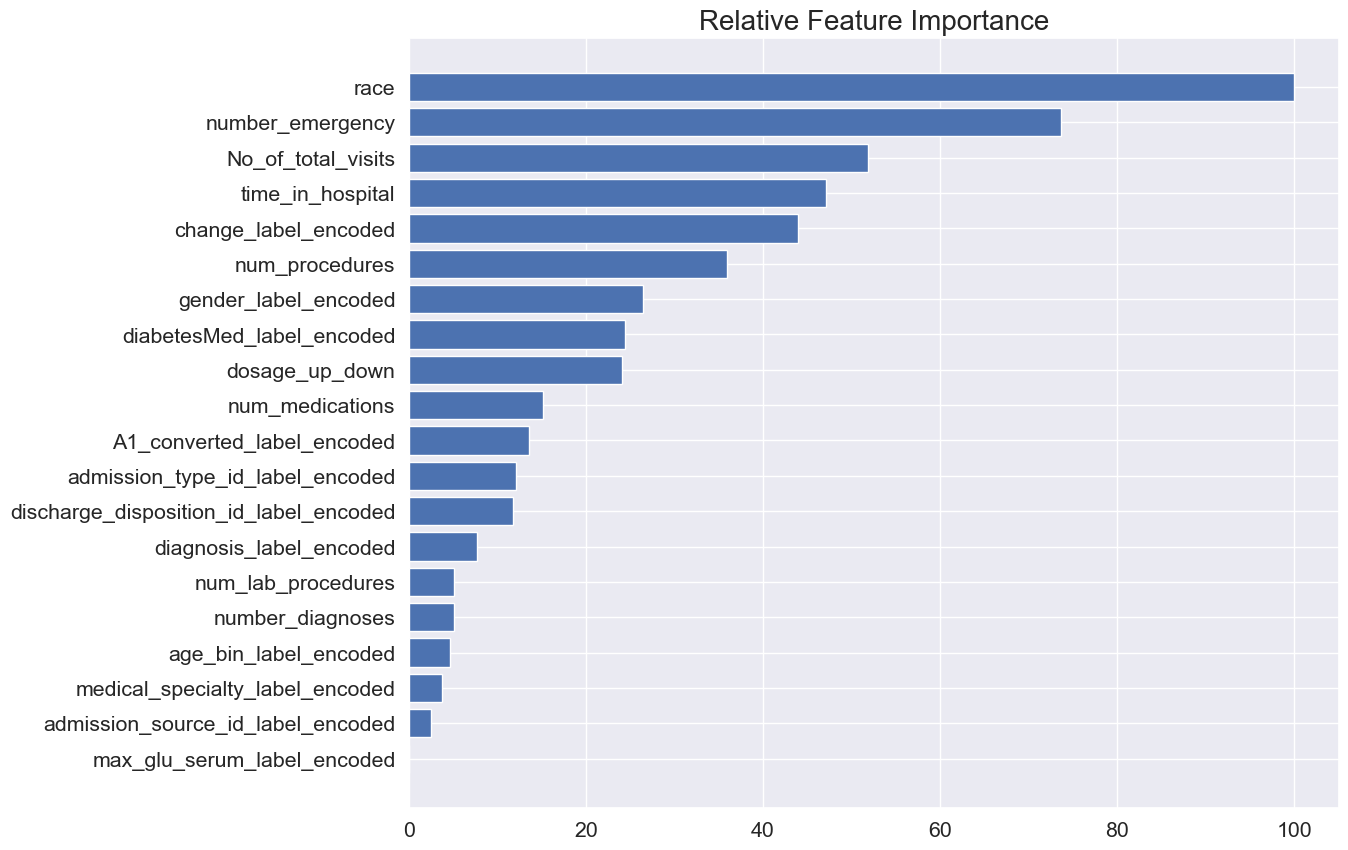

In [109]:
importances = model_rf.feature_importances_

# make importance relative to the max importance
feature_importance = 100.0 * (importances / importances.max())
sorted_idx = np.argsort(feature_importance)
feature_names = list(X_train_scaled.columns.values)
feature_names_sort = [feature_names[indice] for indice in sorted_idx]
pos = np.arange(sorted_idx.shape[0]) + .5


# plot the result
plt.figure(figsize=(12, 10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, feature_names_sort)
plt.title('Relative Feature Importance', fontsize=20)
plt.show()

In [110]:
#XGBOOST model

Execution time of XGBOOST is: 2.925 seconds
XGBoost Accuracy: 0.82
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.98      0.90      9210
           1       0.47      0.10      0.16      2024

    accuracy                           0.82     11234
   macro avg       0.65      0.54      0.53     11234
weighted avg       0.77      0.82      0.77     11234



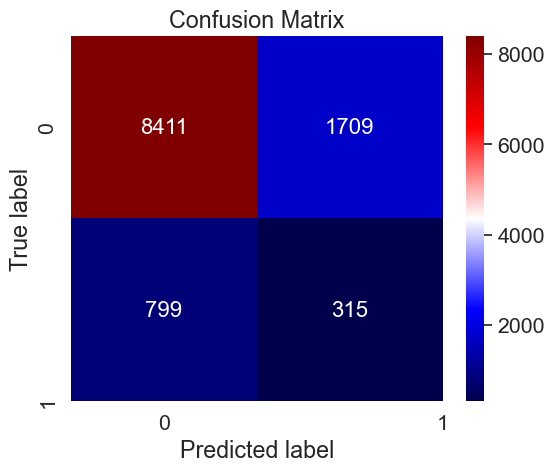

In [111]:
# Initialize the XGBoost classifier
from xgboost import XGBClassifier
start = time.time()

xgb = XGBClassifier(random_state = 42)
xgb.fit(X_train_scaled, y_train_res)
y_pred_xgb = xgb.predict(X_test_scaled)



#Time
XGb_duration = time.time()-start

# Evaluate the model
accuracy_xgb = accuracy_score(y_test_encoded, y_pred_xgb)
#conf_matrix_xgb = confusion_matrix(y_test_encoded, y_pred_xgb)
class_report_xgb = classification_report(y_test_encoded, y_pred_xgb)

#Print
print(f'Execution time of XGBOOST is: {XGb_duration:.3f} seconds')
print(f'XGBoost Accuracy: {accuracy_xgb:.2f}')

print('XGBoost Classification Report:')
print(class_report_xgb)
conf_mat(y_test_encoded, y_pred_test)


In [112]:
from sklearn.ensemble import AdaBoostClassifier

In [113]:
# Initialize the AdaBoost classifier
ada_classifier = AdaBoostClassifier()

# Fit the model on the training data
ada_classifier.fit(X_train_scaled, y_train_res)

# Predict on the test data
y_pred_ada = ada_classifier.predict(X_test_scaled)


Execution time of Decision Tree is: 6.476 seconds
AdaBoost Accuracy: 0.76
AdaBoost Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.88      0.86      9210
           1       0.25      0.17      0.20      2024

    accuracy                           0.76     11234
   macro avg       0.54      0.53      0.53     11234
weighted avg       0.72      0.76      0.74     11234



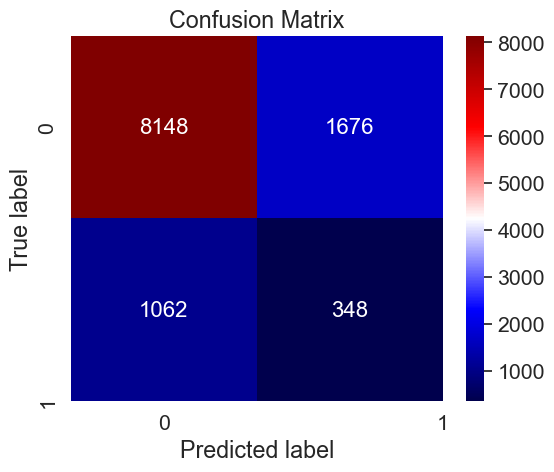

In [114]:
# Evaluate the model
accuracy_ada = accuracy_score(y_test_encoded, y_pred_ada)
#conf_matrix_ada = confusion_matrix(y_test_encoded, y_pred_ada)
class_report_ada = classification_report(y_test_encoded, y_pred_ada)

#Time
Adaboost_duration = time.time()-start

print(f'Execution time of Decision Tree is: {Adaboost_duration:.3f} seconds')
print(f'AdaBoost Accuracy: {accuracy_ada:.2f}')
print('AdaBoost Classification Report:')
print(class_report_ada)
conf_mat(y_test_encoded, y_pred_ada)


Accuracy: 0.63

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.68      0.75      9210
           1       0.22      0.42      0.29      2024

    accuracy                           0.63     11234
   macro avg       0.53      0.55      0.52     11234
weighted avg       0.73      0.63      0.67     11234


Confusion Matrix:


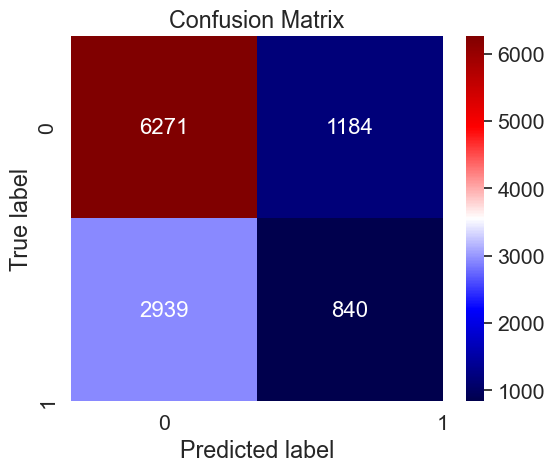

None
Execution time of Decision Tree is: 7.043 seconds


In [115]:
#Instantiate the logistic regression model
log_reg = LogisticRegression()

# Train the model on the training data
log_reg.fit(X_train_scaled, y_train_res)

# Predict the target values for the test set
y_pred_log_reg = log_reg.predict(X_test_scaled)


#Time
LR_duration = time.time()-start


# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test_encoded, y_pred_log_reg)
print(f'Accuracy: {accuracy:.2f}')

# Generate the classification report
print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred_log_reg))

# Generate the confusion matrix
print("\nConfusion Matrix:")
print(conf_mat(y_test_encoded, y_pred_log_reg))
print(f'Execution time of Decision Tree is: {LR_duration:.3f} seconds')

In [116]:
# Instantiate the SVM classifier
from sklearn.svm import SVC
svm_model = SVC(kernel='linear', random_state=42)

# Train the model on the training data
svm_model.fit(X_train_scaled, y_train_res)
# Predict the target values for the test set
y_pred_svc = svm_model.predict(X_test_scaled)

Accuracy: 0.64

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.68      0.76      9210
           1       0.23      0.42      0.29      2024

    accuracy                           0.64     11234
   macro avg       0.53      0.55      0.52     11234
weighted avg       0.73      0.64      0.67     11234

Execution time of Decision Tree is: 201.823 seconds

Confusion Matrix:


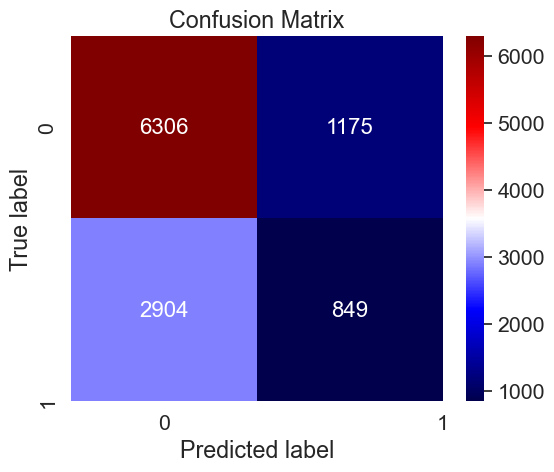

None


In [117]:
 #Evaluate the accuracy of the model
accuracy = accuracy_score(y_test_encoded, y_pred_svc)
print(f'Accuracy: {accuracy:.2f}')


#Time
svm_duration = time.time()-start

# Generate the classification report
print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred_svc))
print(f'Execution time of Decision Tree is: {svm_duration:.3f} seconds')
# Generate the confusion matrix
print("\nConfusion Matrix:")
print(conf_mat(y_test_encoded, y_pred_svc))

In [118]:
#Hyper parameter Tuning 

#Xgboost and  Ada boost are giving best result interms of  accuracy and seconds, So I will apply hyperparameter tuning.

In [119]:
#XGB hyperparameter tuning

In [120]:
param_grid = {
    'eta': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'n_estimators': [100, 200, 300],
    'alpha': [0, 0.1, 1],
    'lambda': [1, 1.5, 2],
}

In [121]:
from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_grid, 
                                   n_iter=100, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
random_search.fit(X_train_scaled, y_train_res)
xgb_duration = time.time()-start
best_params = random_search.best_params_
best_score = random_search.best_score_
xgb_duration

Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
2 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Dell\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Dell\anaconda3\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\Dell\anaconda3\Lib\site-packages\xgboost\sklearn.py", line 1512, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
                           ^^

544.3301603794098

In [122]:
best_params

{'subsample': 0.9,
 'n_estimators': 300,
 'min_child_weight': 5,
 'max_depth': 5,
 'lambda': 1,
 'gamma': 0,
 'eta': 0.1,
 'colsample_bytree': 0.7,
 'alpha': 0.1}

In [123]:
xgb_best = XGBClassifier(**best_params)
xgb_best.fit(X_train_scaled, y_train_res)

y_pred_xgboost = xgb_best.predict(X_test_scaled)
accuracy = accuracy_score(y_test_encoded, y_pred_xgboost)
print("Best Accuracy: {:.2f}%".format(accuracy * 100))

Best Accuracy: 82.40%


### Checking disperate impact after applying model 

In [124]:
dataset_pred = test_set.copy()
dataset_pred['readmitted'] = y_pred_xgboost



In [125]:
# Making our data into a Binary label dataset for prediction dataset
aif_fair_model = BinaryLabelDataset(favorable_label = 1, unfavorable_label = 0, df=dataset_pred,
                                                      label_names=["readmitted"],
                                                     protected_attribute_names=["race"],
                                              privileged_protected_attributes = [1,1])

In [126]:
bin_metric = BinaryLabelDatasetMetric(aif_fair_model, 
                                     unprivileged_groups=[{"race":0}],
                                      privileged_groups=[{"race":1}]) 

disparate_impact_bin = bin_metric.disparate_impact()
print('Disparate impact: ', disparate_impact_bin)
mean_difference = bin_metric.mean_difference()
print('Mean difference: ', mean_difference)



Disparate impact:  0.7265578983753889
Mean difference:  -0.008195722983593428


In [127]:
### The disperate impact of the model is showing significant bias towards privileged_groups.

In [128]:
#Making the trainset and testset binary

In [129]:
trainset_binary = BinaryLabelDataset(favorable_label = 1, unfavorable_label = 0, df=train_set,
                                                      label_names=["readmitted"],
                                                     protected_attribute_names=["race"],
                                              privileged_protected_attributes = [1,1])

In [130]:
test_set_binary = BinaryLabelDataset(favorable_label = 1, unfavorable_label = 0, df=test_set,
                                                      label_names=["readmitted"],
                                                     protected_attribute_names=["race"],
                                              privileged_protected_attributes = [1,1])

In [131]:
classif_metric = ClassificationMetric(test_set_binary,aif_fair_model, 
                                      unprivileged_groups=[{"race":0}],
                                      privileged_groups=[{"race":1}])

#classif_disparate_impact = classif_metric.disparate_impact()
avg_odds = classif_metric.average_odds_difference()
print('Average odds difference:', avg_odds)
equal_opport = classif_metric.equal_opportunity_difference()
print('Equality of opportunity:', equal_opport)
false_discovery_rate = classif_metric.false_discovery_rate_difference()
print('False discovery rate difference:', false_discovery_rate)

Average odds difference: -0.009604424816093445
Equality of opportunity: -0.013209494324045418
False discovery rate difference: -0.05504761904761907


In [132]:
trainset_binary_original=trainset_binary.copy()
test_set_binary_original=test_set_binary.copy()

In [133]:
### Mitigation method(Pre-Processing)Attempt 1. Applying reweighing method on  main trainset

In [134]:
# Making our data into a Binary label dataset for prediction dataset

#2nd cell content
RW = Reweighing(unprivileged_groups=[{"race":0}],
                privileged_groups=[{"race":1}]) 
RW.fit(trainset_binary)
dataset_tf_train = RW.transform(trainset_binary)

dataset_tf_train

               instance weights            features                   \
                                protected attribute                    
                                               race time_in_hospital   
instance names                                                         
17950                  1.008848                 1.0         3.464102   
66488                  0.961663                 1.0         2.000000   
58696                  1.008848                 1.0         1.732051   
29965                  0.961663                 1.0         3.316625   
67520                  0.961663                 1.0         1.732051   
...                         ...                 ...              ...   
82814                  1.008848                 1.0         1.000000   
96912                  0.961663                 1.0         2.236068   
71839                  0.975203                 0.0         1.732051   
2358                   1.008848                 1.0         1.73

In [135]:
#3rd cell content
metric_transf = BinaryLabelDatasetMetric(dataset_tf_train,
                                          unprivileged_groups=[{"race":0}],
                                          privileged_groups=[{"race":1}]) 

metric_orig = BinaryLabelDatasetMetric(dataset_tf_train,
                                       unprivileged_groups=[{"race":0}],
                                       privileged_groups=[{"race":1}]) 
disparate_impact_orig = MetricTextExplainer(metric_orig).disparate_impact()
print(disparate_impact_orig)

Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 1.0000000000000002


In [136]:
# APPLYING MODEL WITH REWEIGHNING 

In [137]:
scale_tf = StandardScaler().fit(dataset_tf_train.features) 
X_train_tf = scale_tf.transform(dataset_tf_train.features)  
y_train = dataset_tf_train.labels.ravel()


In [138]:
X_test_tf = scale_tf.transform(test_set_binary.features) 
y_test = test_set_binary.labels.ravel()

In [139]:
#Running XGBOOST Model on the transformed data after implementing reweighing
#model_tf_rf = RandomForestClassifier(n_estimators=300,min_samples_split=10, max_depth=10,n_jobs=-1)
xgb_best.fit(X_train_tf, y_train,sample_weight=dataset_tf_train.instance_weights)


XGBClassifier(alpha=0.1, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric=None,
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None, lambda=1,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300, ...)

In [140]:
#predicted score from RF model on the transformed (reweighed) dataset
y_pred_test_tf = xgb_best.predict(X_test_tf)
acc_test = accuracy_score(y_true=y_test, y_pred=y_pred_test_tf)
print("Test accuracy: ", acc_test)

Test accuracy:  0.8254406266690404


In [141]:
dataset_pred_tf = test_set.copy()
dataset_pred_tf['readmitted'] = y_pred_test_tf

In [142]:
# Making our data into a Binary label dataset for prediction reweighed dataset
aif_fair_model_tf = BinaryLabelDataset(favorable_label = 1, unfavorable_label = 0, df=dataset_pred_tf,
                                                      label_names=["readmitted"],
                                                     protected_attribute_names=["race"],
                                              privileged_protected_attributes = [1,1])

In [143]:
bin_metric_tf = BinaryLabelDatasetMetric(aif_fair_model_tf, 
                                     unprivileged_groups=[{"race":0}],
                                      privileged_groups=[{"race":1}]) 

disparate_impact_bin_tf = bin_metric_tf.disparate_impact()
print('Disparate impact after the reweighing method: ', disparate_impact_bin_tf)
mean_difference_tf = bin_metric_tf.mean_difference()
print('Mean difference after the reweighing method: ', mean_difference_tf)

Disparate impact after the reweighing method:  0.975399531894623
Mean difference after the reweighing method:  -0.0005928178982353149


In [144]:
### After Reweighing, the disperate impact in the dataset is 0.97, so there is no bias in the model.
    ###But , if bias remains in the dataset, other in-processing mitigation algorithm should be applied.As mitigation should be performed early stages. I have checked with another algorithm disperate impact remover.

In [145]:
#Applying  pre-process algorithm: 2 (Disperate impact remover)

In [146]:
trainset_Binary = BinaryLabelDataset(favorable_label = 1, unfavorable_label = 0, df=train_set,
                                                      label_names=["readmitted"],
                                                     protected_attribute_names=["race"])

In [147]:
from aif360.algorithms.preprocessing import DisparateImpactRemover
# Initialize the DisparateImpactRemover with the sensitive attribute
di_remover = DisparateImpactRemover(repair_level=1.0)

# Apply the transformation
dataset_transformed_train = di_remover.fit_transform(trainset_Binary)




In [148]:
# Initialize the DisparateImpactRemover with the sensitive attribute
di_remover = DisparateImpactRemover(repair_level=1.0)

# Apply the transformation
dataset_transformed_train = di_remover.fit_transform(trainset_Binary)



In [149]:
scale_DIRemoval = StandardScaler().fit(dataset_transformed_train.features) 
X_train_DIRemoval = scale_DIRemoval.transform(dataset_transformed_train.features)  
y_train_DIRemoval = dataset_transformed_train.labels.ravel()


In [150]:
X_test_DIRemoval = scale_DIRemoval.transform(test_set_binary.features) 
y_test_DIRemoval = test_set_binary.labels.ravel()

In [151]:
#Running XGB  Model on the transformed data after implementing reweighing
#model_DIRemoval_rf = RandomForestClassifier(n_estimators=300,min_samples_split=10, max_depth=10,n_jobs=-1)
model_DIRemoval_xgb=xgb_best.fit(X_train_DIRemoval, y_train_DIRemoval,sample_weight=dataset_transformed_train.instance_weights)

In [152]:
#predicted score from RF model on the transformed (reweighed) dataset
y_pred_test_DIRemoval = model_DIRemoval_xgb.predict(X_test_DIRemoval)
acc_test = accuracy_score(y_true=y_test_DIRemoval, y_pred=y_pred_test_DIRemoval)
print("Test accuracy: ", acc_test)

Test accuracy:  0.8212568987003739


In [153]:
dataset_pred_DIRemoval = test_set.copy()
dataset_pred_DIRemoval['readmitted'] = y_pred_test_DIRemoval

dataset_pred_DIRemoval

,race,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_emergency,number_diagnoses,readmitted,No_of_total_visits,dosage_up_down,...,admission_type_id_label_encoded,discharge_disposition_id_label_encoded,admission_source_id_label_encoded,medical_specialty_label_encoded,diabetesMed_label_encoded,diagnosis_label_encoded,A1_converted_label_encoded,age_bin_label_encoded,change_label_encoded,max_glu_serum_label_encoded
52066,0,2.000000,40,1.000000,4.472136,1.414214,5,1,2.828427,0,...,1,5,0,24,1,733,0,1,1,0
37238,0,1.732051,26,2.000000,3.162278,0.000000,9,0,0.000000,1,...,1,0,6,57,1,271,0,2,0,0
72716,1,1.414214,57,1.000000,3.000000,0.000000,9,0,0.000000,0,...,0,0,6,0,1,377,0,1,1,0
50256,0,1.414214,45,0.000000,4.242641,0.000000,7,0,0.000000,0,...,0,0,0,0,1,143,0,1,1,0
96928,0,1.732051,4,1.000000,2.645751,0.000000,6,0,0.000000,0,...,2,0,0,0,1,417,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18944,0,1.414214,54,0.000000,3.000000,1.000000,9,0,0.000000,0,...,0,0,6,17,1,283,0,2,1,0
28552,1,2.828427,65,1.414214,4.358899,0.000000,5,0,0.000000,-1,...,1,0,0,17,1,501,0,2,0,0
12164,1,1.414214,31,0.000000,3.316625,0.000000,5,0,0.000000,0,...,1,0,0,57,1,509,0,2,0,0
77748,0,1.000000,1,1.732051,3.872983,0.000000,6,0,0.000000,0,...,2,0,0,62,1,345,0,2,1,0


In [154]:
# Making our data into a Binary label dataset for prediction reweighed dataset
aif_fair_model_DIRemoval = BinaryLabelDataset(favorable_label = 1, unfavorable_label = 0, df=dataset_pred_DIRemoval,
                                                      label_names=["readmitted"],
                                                     protected_attribute_names=["race"],
                                              privileged_protected_attributes = [1,1])

In [155]:
bin_metric_DIRemoval = BinaryLabelDatasetMetric(aif_fair_model_DIRemoval, 
                                     unprivileged_groups=[{"race":0}],
                                      privileged_groups=[{"race":1}]) 

disparate_impact_bin_DIremoval = bin_metric_DIRemoval.disparate_impact()
print('Disparate impact after the DI remover method: ', disparate_impact_bin_DIremoval)
mean_difference_DIremoval = bin_metric_DIRemoval.mean_difference()
print('Mean difference after the DI remover method: ', mean_difference_DIremoval)

Disparate impact after the DI remover method:  0.5816914391058877
Mean difference after the DI remover method:  -0.011434402575693274


In [156]:
As Disparity between privileged and unprivileged groups have increased, further pre-percessing or in-processing algorithms should be applied.

SyntaxError: invalid syntax (1322384797.py, line 1)

### Trying in process methods: 1.Adversial debiasing and prejudice remover (In-processing algorithm)

In [157]:
trainset_Binary_adb = BinaryLabelDataset(favorable_label = 1, unfavorable_label = 0, df=train_set,
                                                      label_names=["readmitted"],
                                                     protected_attribute_names=["race"])
#trainset_Binary_final=trainset_Binary_adb.copy()
    

In [158]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution 

<function tensorflow.python.framework.ops.disable_eager_execution() -> None>

In [159]:
from tensorflow.python.framework.ops import disable_eager_execution

In [160]:
# Define the adversarial debiasing model
sess = tf.compat.v1.Session()

plain_model = AdversarialDebiasing(privileged_groups=[{'race': 1}],
                          unprivileged_groups=[{'race': 0}],
                          scope_name='plain_classifier',
                          debias=False,
                          sess=sess)

In [161]:
disable_eager_execution()

In [162]:
# Train the model
plain_model.fit(trainset_Binary_adb)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


epoch 0; iter: 0; batch classifier loss: 9.210077
epoch 0; iter: 200; batch classifier loss: 1.820934
epoch 1; iter: 0; batch classifier loss: 0.577093
epoch 1; iter: 200; batch classifier loss: 0.479790
epoch 2; iter: 0; batch classifier loss: 0.485033
epoch 2; iter: 200; batch classifier loss: 0.451634
epoch 3; iter: 0; batch classifier loss: 0.478300
epoch 3; iter: 200; batch classifier loss: 0.393022
epoch 4; iter: 0; batch classifier loss: 0.506473
epoch 4; iter: 200; batch classifier loss: 0.562468
epoch 5; iter: 0; batch classifier loss: 0.426739
epoch 5; iter: 200; batch classifier loss: 0.498062
epoch 6; iter: 0; batch classifier loss: 0.356642
epoch 6; iter: 200; batch classifier loss: 0.480764
epoch 7; iter: 0; batch classifier loss: 0.425903
epoch 7; iter: 200; batch classifier loss: 0.435290
epoch 8; iter: 0; batch classifier loss: 0.388285
epoch 8; iter: 200; batch classifier loss: 0.462030
epoch 9; iter: 0; batch classifier loss: 0.374581
epoch 9; iter: 200; batch classi

In [163]:
#Apply the plain model to test data(to predict in testdata)
dataset_nodebiasing_train = plain_model.predict(trainset_Binary_adb)
dataset_nodebiasing_test = plain_model.predict(test_set_binary)

In [164]:
# Metrics for the dataset from plain model (without debiasing)
#display(Markdown("#### Plain model - without debiasing - dataset metrics"))
metric_dataset_nodebiasing_train = BinaryLabelDatasetMetric(dataset_nodebiasing_train, 
                                            unprivileged_groups=[{'race': 0}],
                                            privileged_groups=[{'race': 1}])

print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_train.mean_difference())

metric_dataset_nodebiasing_test = BinaryLabelDatasetMetric(dataset_nodebiasing_test, 
                                             unprivileged_groups=[{'race':0}],
                                             privileged_groups=[{'race':1}])

print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_test.mean_difference())

#display(Markdown("#### Plain model - without debiasing - classification metrics"))


Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.000585
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.000810


In [165]:
classified_metric_nodebiasing_test = ClassificationMetric(test_set_binary, 
                                                 dataset_nodebiasing_test,
                                                 unprivileged_groups=[{'race':0}],
                                                 privileged_groups=[{'race':1}])
print("Test set: Classification accuracy = %f" % classified_metric_nodebiasing_test.accuracy())
TPR = classified_metric_nodebiasing_test.true_positive_rate()
TNR = classified_metric_nodebiasing_test.true_negative_rate()
bal_acc_nodebiasing_test = 0.5*(TPR+TNR)
print("Test set: Balanced classification accuracy = %f" % bal_acc_nodebiasing_test)
print("Test set: Disparate impact = %f" % classified_metric_nodebiasing_test.disparate_impact())
print("Test set: Equal opportunity difference = %f" % classified_metric_nodebiasing_test.equal_opportunity_difference())
print("Test set: Average odds difference = %f" % classified_metric_nodebiasing_test.average_odds_difference())
print("Test set: Theil_index = %f" % classified_metric_nodebiasing_test.theil_index())

Test set: Classification accuracy = 0.821524
Test set: Balanced classification accuracy = 0.509127
Test set: Disparate impact = 0.864950
Test set: Equal opportunity difference = 0.002006
Test set: Average odds difference = 0.000442
Test set: Theil_index = 0.195060


### Now applying this method with debiasing parameter in trainset

In [166]:
tf.compat.v1.disable_eager_execution
sess = tf.compat.v1.Session()


In [167]:
trainset_Binary_withdb = BinaryLabelDataset(favorable_label = 1, unfavorable_label = 0, df=train_set,
                                                      label_names=["readmitted"],
                                                     protected_attribute_names=["race"])


In [168]:
# Learn parameters with debias set to True
debiased_model = AdversarialDebiasing(privileged_groups = [{'race':1}],
                          unprivileged_groups = [{'race':0}],
                          scope_name='debiased_classifier',
                          debias=True,
                          sess=sess)


In [169]:
#debiased_model.fit(trainset_Binary_withdb)


In [170]:
debiased_model.fit(trainset_Binary_withdb)

epoch 0; iter: 0; batch classifier loss: 4.710320; batch adversarial loss: 0.864207
epoch 0; iter: 200; batch classifier loss: 1.041650; batch adversarial loss: 0.841034
epoch 1; iter: 0; batch classifier loss: 0.826350; batch adversarial loss: 0.724648
epoch 1; iter: 200; batch classifier loss: 0.653939; batch adversarial loss: 0.641631
epoch 2; iter: 0; batch classifier loss: 0.479981; batch adversarial loss: 0.618525
epoch 2; iter: 200; batch classifier loss: 0.623254; batch adversarial loss: 0.577057
epoch 3; iter: 0; batch classifier loss: 0.537131; batch adversarial loss: 0.616258
epoch 3; iter: 200; batch classifier loss: 0.491176; batch adversarial loss: 0.577833
epoch 4; iter: 0; batch classifier loss: 0.483767; batch adversarial loss: 0.554928
epoch 4; iter: 200; batch classifier loss: 0.562672; batch adversarial loss: 0.622162
epoch 5; iter: 0; batch classifier loss: 0.500770; batch adversarial loss: 0.543163
epoch 5; iter: 200; batch classifier loss: 0.506119; batch adversa

In [171]:
# Apply the plain model to test data
dataset_debiasing_train = debiased_model.predict(trainset_Binary_withdb)
dataset_debiasing_test = debiased_model.predict(test_set_binary)

In [172]:
# Metrics for the dataset from plain model (without debiasing)
#display(Markdown("#### Plain model - without debiasing - dataset metrics"))
metric_dataset_withdebiasing_train = BinaryLabelDatasetMetric(dataset_debiasing_train, 
                                            unprivileged_groups=[{'race': 0}],
                                            privileged_groups=[{'race': 1}])

print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_train.mean_difference())

metric_dataset_withdebiasing_test = BinaryLabelDatasetMetric(dataset_debiasing_test, 
                                             unprivileged_groups=[{'race':0}],
                                             privileged_groups=[{'race':1}])

print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_nodebiasing_test.mean_difference())

#display(Markdown("#### Plain model - without debiasing - classification metrics"))


Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.000585
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.000810


In [173]:
classified_metric_withdebiasing_test = ClassificationMetric(test_set_binary, 
                                                 dataset_debiasing_test,
                                                 unprivileged_groups=[{'race':0}],
                                                 privileged_groups=[{'race':1}])
print("Test set: Classification accuracy = %f" % classified_metric_withdebiasing_test.accuracy())
TPR = classified_metric_withdebiasing_test.true_positive_rate()
TNR = classified_metric_withdebiasing_test.true_negative_rate()
bal_acc_debiasing_test = 0.5*(TPR+TNR)
print("Test set: Balanced classification accuracy = %f" % bal_acc_debiasing_test)
print("Test set: Disparate impact = %f" % metric_dataset_withdebiasing_test.disparate_impact())
print("Test set: Equal opportunity difference = %f" % classified_metric_withdebiasing_test.equal_opportunity_difference())
print("Test set: Average odds difference = %f" % classified_metric_withdebiasing_test.average_odds_difference())
print("Test set: Theil_index = %f" % classified_metric_withdebiasing_test.theil_index())

Test set: Classification accuracy = 0.820901
Test set: Balanced classification accuracy = 0.503735
Test set: Disparate impact = 2.358954
Test set: Equal opportunity difference = 0.008288
Test set: Average odds difference = 0.004414
Test set: Theil_index = 0.197087


In [174]:
### PRejudice remover
from aif360.algorithms.inprocessing import PrejudiceRemover

In [175]:
trainset_Binary_pr = BinaryLabelDataset(favorable_label = 1, unfavorable_label = 0, df=train_set,
                                                      label_names=["readmitted"],
                                                     protected_attribute_names=["race"])

In [176]:
testset_Binary_pr = BinaryLabelDataset(favorable_label = 1, unfavorable_label = 0, df=test_set,
                                                      label_names=["readmitted"],
                                                     protected_attribute_names=["race"])

In [177]:
# Initialize Prejudice Remover model
pr = PrejudiceRemover(sensitive_attr='race', eta=25.0)


In [178]:

# Train the model
pr.fit(trainset_Binary_pr)


In [179]:
# Make predictions
dataset_debiasing_train = pr.predict(trainset_Binary_pr)
dataset_debiasing_test = pr.predict(testset_Binary_pr)


In [180]:
# Evaluate the model
classified_metric_train = ClassificationMetric(
    trainset_Binary_pr,
    dataset_debiasing_train,
    unprivileged_groups=[{'race': 0}],
    privileged_groups=[{'race': 1}]
)
classified_metric_test = ClassificationMetric(
    testset_Binary_pr,
    dataset_debiasing_test,
    unprivileged_groups=[{'race': 0}],
    privileged_groups=[{'race': 1}]
)

In [181]:
# Calculate and print Disparate Impact and other fairness metrics
def print_fairness_metrics(metric, dataset_name):
    disparate_impact = metric.disparate_impact()
    statistical_parity_difference = metric.statistical_parity_difference()
    equal_opportunity_difference = metric.equal_opportunity_difference()
    average_odds_difference = metric.average_odds_difference()
    
    print(f"{dataset_name} Fairness Metrics:")
    print(f"  Disparate Impact: {disparate_impact:.4f}")
    print(f"  Statistical Parity Difference: {statistical_parity_difference:.4f}")
    print(f"  Equal Opportunity Difference: {equal_opportunity_difference:.4f}")
    print(f"  Average Odds Difference: {average_odds_difference:.4f}")
    print()

In [182]:
# Metrics for original and debiased datasets
metric_orig_train = BinaryLabelDatasetMetric(
    trainset_Binary_pr,
    unprivileged_groups=[{'race': 0}],
    privileged_groups=[{'race': 1}]
)
metric_debias_train = ClassificationMetric(
    trainset_Binary_pr,
    dataset_debiasing_train,
    unprivileged_groups=[{'race': 0}],
    privileged_groups=[{'race': 1}]
)
metric_debias_test = ClassificationMetric(
    testset_Binary_pr,
    dataset_debiasing_test,
    unprivileged_groups=[{'race': 0}],
    privileged_groups=[{'race': 1}]
)

# Print fairness metrics
metric_orig_train.disparate_impact()
print("Test set: Disparate impact = %f" % metric_debias_test.disparate_impact())
# Print accuracy
print("Train set: Classification accuracy = {:.4f}".format(classified_metric_train.accuracy()))
print("Test set: Classification accuracy = {:.4f}".format(classified_metric_test.accuracy()))

Test set: Disparate impact = 0.961055
Train set: Classification accuracy = 0.8204
Test set: Classification accuracy = 0.8211


In [183]:
#applyiny SHAP: Explainable AI 

In [184]:
import shap
shap.initjs()

In [ ]:
# Initialize SHAP explainer
explainer = shap.TreeExplainer(xgb_best, X_train_scaled)

# Calculate SHAP values for the test set
shap_values = explainer(X_test_scaled)

# Plot the SHAP values
shap.summary_plot(shap_values, X_test_scaled)

Feature value high= red, low=blue. The color of each feature indicates its value. This can be especially important in describing the models behavior and each feature values impact. Time in hospital is most important feature here. red colour indicates high no of time stayed in hospital.

In [ ]:
# Load the California housing dataset
# Specify the name of the target column
target_column = 'readmitted'  # Replace 'target' with your actual target column name

# Split the dataset into features (X) and target (y)
X = raw_df.drop(columns=[target_column])
y = raw_df[target_column]


In [ ]:
# Plot the SHAP values
shap.summary_plot(shap_values, plot_type="bar",feature_names=X.columns)

In [ ]:
#Local Interpretability explainability of individual prediction that has been made by the model.

In [ ]:
shap_df = pd.DataFrame(shap_values, columns=X, index=X_test_scaled.index)
idx = 123
shap.force_plot(explainer.expected_value, 
                shap_df.reset_index(drop=True).iloc[idx].values, 
                X_test_scaled.reset_index(drop=True).iloc[idx])

In [ ]:
#Checking disperate impact on main dataset

In [ ]:
train_set_latest=train_set.copy()
test_set_latest=test_set.copy()

In [ ]:
test_set_latest

In [ ]:
train_set_latest.to_excel("trainset_final.xlsx",index=False)
test_set_latest.to_excel("testset_final.xlsx",index=False)